# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot
 - Add **Visualisation** : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - Save each case, not each run. don't run cases that have already been computed.

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
### Import and Paths

In [85]:
import os
import pandas as pd
import numpy as np
import pickle
import traceback
import multiprocessing
import random
from datetime import datetime as dt
from time import time
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [3]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
n_jobs = multiprocessing.cpu_count()

In [5]:
seed = 84

In [95]:
plt.rcParams['figure.figsize'] = 13, 8

In [96]:
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
path_ref_db = "/home/ubuntu/Data/NCBI/Bacteria_2015/"
path_kmer_freq = "/home/ubuntu/Data/kmer_freq/"

In [9]:
path_4mer = "4mer/V4/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [10]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")
print(f"{os.path.isfile(path_all)} path_all")

True path_all


## Main dataset

Load the whole dataset. Will take a while !!

In [11]:
all_df = pd.read_pickle(path_all)

In [12]:
cols_kmers = all_df.columns.to_list()[4:]

In [13]:
cols_spe = sorted(list(set(all_df.columns.to_list()).difference(set(cols_kmers))))

In [14]:
all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
209,Saprospira_grandis_Lewin_uid89375,NC_016940,4345237,2040000,195,58,129,102,40,31,...,22,40,52,43,95,41,49,55,89,115
154,Pasteurella_multocida_Pm70_uid57627,NC_002663,2257487,1540000,145,88,65,110,73,47,...,34,51,79,50,44,60,82,48,57,85
5,candidate_division_WWE3_bacterium_RAAC2_WWE3_1...,NC_023001,878109,50000,188,67,125,94,56,37,...,46,44,66,24,37,53,53,61,52,85
307,Azoarcus_KH32C_uid193704,NC_020516,5081166,3070000,6,9,12,13,17,23,...,81,14,21,44,10,13,1,19,10,7
305,Streptomyces_cattleya_NRRL_8057___DSM_46488_ui...,NC_017586,6282967,1240000,1,1,3,0,24,20,...,47,12,13,16,16,6,0,5,2,0


In [16]:
unique_bacteria = len(all_df.bacteria.unique())
unique_bacteria

2782

2782

## Reduction possibilities

### PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [17]:
components = 20
cols_lda = [f"lda_{i+1}" for i in range(components)]

In [18]:
pca = PCA(n_components=components)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

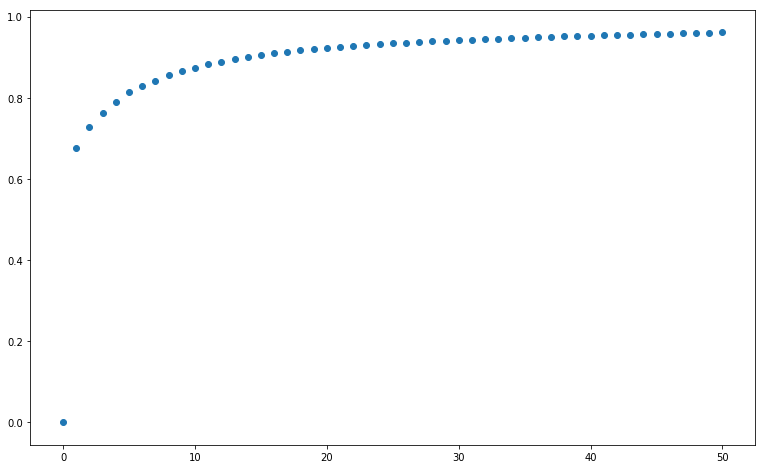

captured by PCA: 96.1%


In [19]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [20]:
cols_pca = [f"pca_{i+1}" for i in range(components)]

In [21]:
np_pca = pca.transform(all_df[cols_kmers])
df_pca = pd.DataFrame(np_pca, columns=cols_pca)
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i
df_pca.shape

(10000, 55)

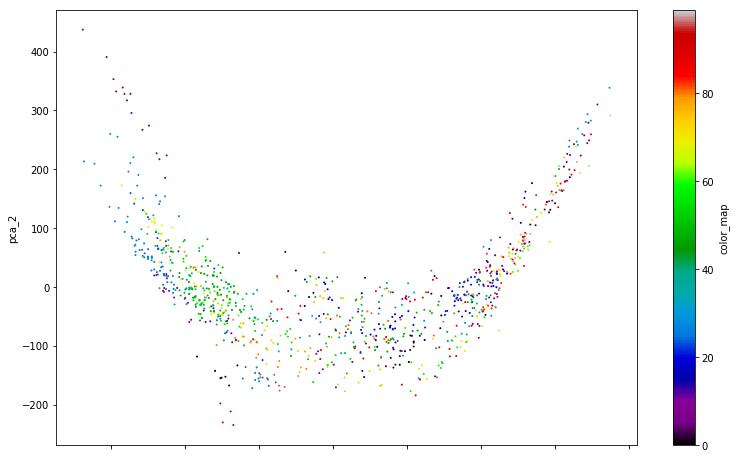

captured by PCA: 72.9%


In [22]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

### LDA Linear Discriminant Analysis
Another dimension reduction

In [18]:
lda = LinearDiscriminantAnalysis(n_components=components)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by LDA: 77.7%


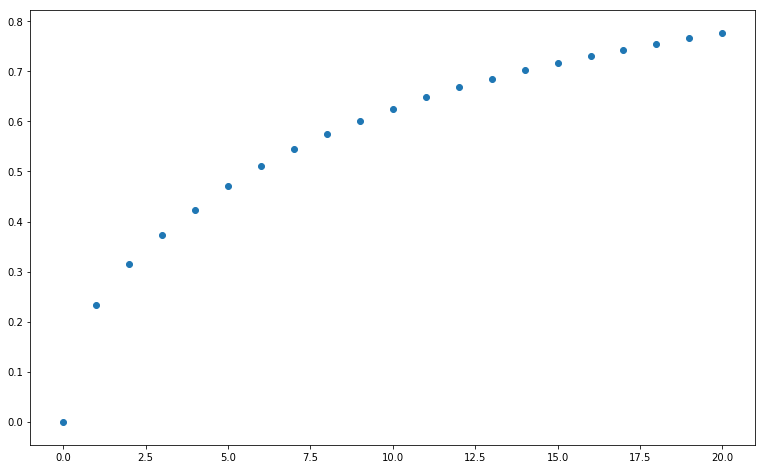

captured by LDA: 77.7%


In [19]:
plt.scatter(x=range(len(lda.explained_variance_ratio_)+1), 
            y=np.insert(lda.explained_variance_ratio_.cumsum(), 0, 0),)
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

In [20]:
np_lda = lda.transform(all_df[cols_kmers])
cols_lda = [f"lda_{i+1}" for i in range(components)]
df_lda = pd.DataFrame(np_lda, columns=cols_lda)
df_lda = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_lda], axis=1) # , ignore_index=True)
df_lda["color_map"] = 0
for i, bacteria in enumerate(df_lda.bacteria.unique()):
    df_lda.loc[df_lda["bacteria"] == bacteria, ['color_map']] = i

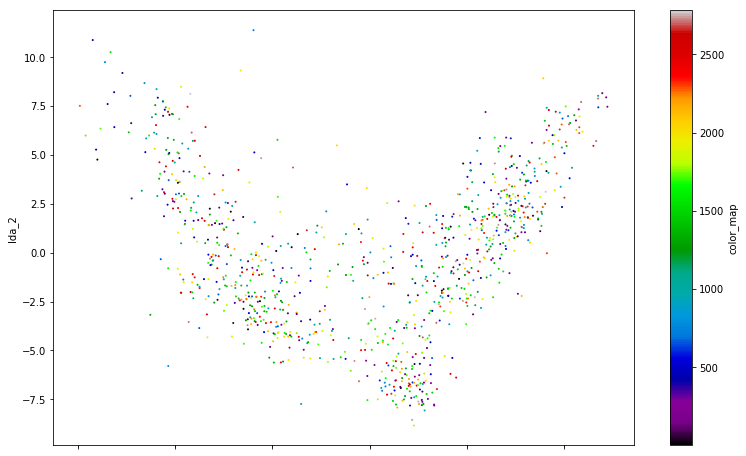

captured by LDA: 31.6%


In [21]:
df_lda.sample(1000).plot.scatter(x="lda_1", y="lda_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_[:2])*100:0.1f}%")

In [22]:
df_lda.sample(5)

,bacteria,fna,len_genome,start,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,...,lda_12,lda_13,lda_14,lda_15,lda_16,lda_17,lda_18,lda_19,lda_20,color_map
812088,Leptospirillum_ferrooxidans_C2_3_uid158171,NC_017094,2559538,360000,-3.09,1.78,-5.90,1.52,1.59,-8.34,...,-1.00,2.08,1.83,0.09,-1.97,1.04,1.50,-0.75,-1.01,2382
433416,Candidatus_Accumulibacter_phosphatis_clade_IIA...,NC_013194,5058518,2590000,-5.29,-1.47,0.28,-1.27,2.16,-0.11,...,-1.29,0.84,-1.57,-0.78,0.42,-0.73,-1.79,0.29,0.36,1267
70555,Xanthomonas_oryzae_oryzicola_BLS256_uid54411,NC_017267,4831739,1140000,-5.24,-3.54,1.84,-1.58,2.46,2.70,...,-1.71,0.08,2.11,0.29,0.71,-0.34,-0.85,-0.06,0.47,209
612441,Burkholderia_glumae_BGR1_uid59397,NC_012724,3906507,3690000,-7.54,-1.75,4.35,2.69,2.40,2.07,...,0.78,-0.33,0.16,-0.93,-2.31,-2.23,-1.00,0.77,-1.46,1803
24178,Acidithiobacillus_ferrooxidans_ATCC_23270_uid5...,NC_011761,2982397,830000,-1.89,-2.85,-4.33,-2.29,-0.72,-0.61,...,0.44,-1.05,1.55,0.85,3.01,-1.13,0.54,0.98,0.45,71


In [23]:
df_lda.shape

(953798, 25)

In [18]:
file_lda_data = f"/home/ubuntu/Data/kmer_freq/4mer/V4/LDA/lda_data_953798_20_int.pd"

In [19]:
file_lda_model = f"/home/ubuntu/Data/kmer_freq/4mer/V4/LDA/lda_model_20_int.pd"

## Functions

In [20]:
def apply_PCA(x, y, components=10):
    cols_pca = [f"pca_{i+1}" for i in range(components)]
    pca = PCA(n_components=components)
    np_pca = pca.fit_transform(x)
    df_pca = pd.DataFrame(np_pca, columns=cols_pca, index=x.index)
    return df_pca, y, sum(pca.explained_variance_ratio_)

In [21]:
def apply_LDA(x, y, components=10):
    cols_lda = [f"lda_{i+1}" for i in range(components)]
    lda = LinearDiscriminantAnalysis(n_components=components)
    np_lda = lda.fit_transform(x, y)
    print(np_lda.shape)
    df_lda = pd.DataFrame(np_lda, columns=cols_lda, index=x.index)
    return df_lda, y, sum(lda.explained_variance_ratio_)

In [22]:
def apply_nothing(x, y, components=None):
    return x, y, 1

In [23]:
dim_reduc = {
    "PCA": apply_PCA,
    "LDA": apply_LDA,
    "raw": apply_nothing,
}

In [24]:
def save_models(path_models, name_run, models, n_classes):
    for model in tqdm(models):
        file_out_path = os.path.join(path_models, f"_{n_classes}_{model}_{name_run}.pkl")
        with open(file_out_path, 'wb') as f_out:
            pickle.dump(models[model], f_out)
            print(f"model {model} saved at {file_out_path}")

In [25]:
def launch_models(models_names, X_train, y_train, X_test, y_test=None, 
                  predict=True, path_models="", name_run="", n_classes=0):
    models = {
        "QDA": QuadraticDiscriminantAnalysis(),
        "Naive_Bayes": GaussianNB(),
        "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=n_jobs),
        "SVM_lin": SVC(kernel="linear", C=0.025),
        "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),   # too slow and memory consumption
        "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=n_jobs),
        "DTree": DecisionTreeClassifier(max_depth=20),
        "NNet": MLPClassifier(alpha=1),    # too slow
        "AdaBoost": AdaBoostClassifier(),  # worse classifier
    }
    results = {}
    for name in tqdm(models_names, disable=False, desc="ML_Models", leave=False, dynamic_ncols=True):
        if name in models.keys():
#             print(name)
            start = time()
            results[name] = {}

            # Train
            models[name].fit(X_train, y_train)
            time_fitted = time()
            results[name]["time_fit"] = time_fitted - start

            if predict:
                # Predict
                predicted = models[name].predict(X_test)
                results[name]["predicted"] = predicted
                time_predicted = time()
                results[name]["time_predict"] = time_predicted - time_fitted

            results[name]["time"] = time() - start
            
            file_out_path = os.path.join(path_models, f"_{n_classes}_{name}_{name_run}.pkl")
            with open(file_out_path, 'wb') as f_out:
                pickle.dump(models[name], f_out)
                print(f"model {name} saved at {file_out_path}")
        
        else:
            models.pop(models)
            
#     if path_models != "" and name_run != "": save_models(path_models, name_run, models, n_classes)
    return results

In [26]:
def pred_accuracy(results, y_test):
    to_df = {"Ground_Truth": y_test}
    for name in results.keys():
        predicted = results[name]["predicted"]
        to_df[f"{name}_pred"] = predicted
        to_df[f"{name}_strand"] = (y_test==predicted).astype(int)
        to_df[f"{name}_species"] = 0
        to_df[f"{name}_genus"] = 0
    pd_res = pd.DataFrame(to_df)

    for name in results.keys():
        # check if the first split of the species name is egal (corresponds to genus level)
        pd_res[f"{name}_genus"] = (pd_res.Ground_Truth.str.split("_", 1).str[0] == \
                                         pd_res[f"{name}_pred"].str.split("_", 1).str[0]).astype(int)
        # Then chec the second, and multiply by the genus (in case some second names are common accross genus)
        pd_res[f"{name}_species"] = ((pd_res.Ground_Truth.str.split("_", 2).str[1] == \
                                            pd_res[f"{name}_pred"].str.split("_", 2).str[1]) \
                                            * pd_res[f"{name}_genus"]).astype(int)
    
    return pd_res

In [27]:
def ranking_ml(pd_res, test_size, results):
    ranking = 100 * pd_res.sum(numeric_only=True) / test_size
    pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                               "percentage": ranking.values})
    for times in ("time", "time_fit", "time_predict", ):
        pd_ranking[times] = 0
        for name in results.keys():
            pd_ranking.loc[pd_ranking["name"].str.contains(name), [times]] = results[name][times]
    return pd_ranking.sort_values(by=["percentage"], ascending=False)

# Pipeline

In [28]:
def run_all_param(df_initial, ml_models, path_4mer=path_4mer, path_models="ml_models/", n_samples=10000, n_bacteria=100,
                  dim_reduc_tool="LDA", components=10, test_ratio=0.1, random_seed=0,):
    
    path_models = os.path.join(path_4mer, path_models)
    if n_bacteria < 0:
        n_bacteria = len(df_initial.bacteria.unique())
        df_down_sampled = df_initial
    else:
        df_down_sampled = df_initial[df_initial.bacteria.isin(df_initial.bacteria.unique()[:n_bacteria])]
    
    if n_samples < 0:
        n_samples = df_down_sampled.shape[0]
    df_down_sampled = df_down_sampled.sample(n_samples, random_state=random_seed)
    test_size = test_ratio * n_samples

    name_run = f"_{dim_reduc_tool}-{'256' if dim_reduc_tool=='raw' else components}" \
               f"_{df_down_sampled.shape[0] if n_samples<0 else n_samples}-samples" \
               f"_{unique_bacteria if n_bacteria<0 else n_bacteria}-bac"
    print(f"\n\n{name_run}")

    y = df_down_sampled["bacteria"]
    x = df_down_sampled[cols_kmers]

    # average each row ?

    x, y, variance_captured = dim_reduc[dim_reduc_tool](x, y, components)
    print(f"Variance captured by {dim_reduc_tool} = {variance_captured*100:.2f}%")

    x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

    results = {}
    try:
        # Save models
        now = dt.now().strftime("%Y-%m-%d_%H-%M")
        results = launch_models(ml_models, X_train, y_train, X_test, y_test, 
                                path_models=path_models, name_run=now, n_classes=n_bacteria)  # name_run
    except Exception as e:
        print("type error: " + str(e))
        print(traceback.format_exc())
        return name_run, results, y_test, variance_captured
        
    pd_res = pred_accuracy(results, y_test)
    pd_res.to_pickle(os.path.join(path_models, f"_{name_run}_results.pd"))

    pd_ranking = ranking_ml(pd_res, test_size, results)
    pd_ranking.to_pickle(os.path.join(path_models, f"_{name_run}_ranking.pd"))
    return name_run, pd_ranking, pd_res, variance_captured

In [29]:
def launch_multiple_cases():
    all_ranking = {}
    all_results = {}
    all_dim_reduc = {}
    guard = 0
    stop = 80

    for n_s in tqdm(sample_sizes, desc="#Sample", dynamic_ncols=True):  # 10000,
        for n_b in tqdm(bacteria_number, desc="#Bacteria", dynamic_ncols=True, leave=False):
            for dim_r in tqdm(dimension_reductions, desc="DimReduc", dynamic_ncols=True, leave=False):  # "raw", 

                # Some combination are not worth or too slow, skip them
                if n_s == 10000 and (n_b <= 0 or 500 < n_b):                 continue
                if dim_r == "raw" and n_s == -1 and (n_b <= 0 or 200 < n_b): continue

                name, pd_ranking, pd_res, variance_captured = \
                    run_all_param(all_all_df, ml_models, n_samples=n_s, n_bacteria=n_b, 
                                  dim_reduc_tool=dim_r, components=20, random_seed=7)

                if not isinstance(pd_ranking, dict): print(pd_ranking[:10])
                all_ranking[name] = pd_ranking
                all_results[name] = pd_res
                all_dim_reduc[name] = variance_captured
                print(pd_ranking[["time_fit", "time_predict"]].describe().loc[["mean"]])

                guard += 1
                if guard>stop: break
            if guard>stop: break
        if guard>stop: break

    path_models = os.path.join(path_4mer, "ml_models/")
    now = dt.now().strftime("%Y-%m-%d_%H-%M")
    with open(os.path.join(path_models, f"_all_results_{now}.pkl"), 'wb') as f: pickle.dump(all_results, f)
    with open(os.path.join(path_models, f"_all_rankings_{now}.pkl"), 'wb') as f: pickle.dump(all_ranking, f)
    print("Finished !")

In [30]:
x = pd.read_pickle(file_lda_data)

In [31]:
x = x[x.bacteria != "Bacteroides_uniformis_uid13130"]

In [32]:
def launch_ml_on_lda_file():
    
    x = pd.read_pickle(file_lda_data)
    print(x.shape)
    # apparently only 1 windows from each of those
    x = x[False == x.bacteria.str.contains('Bacteroides_uniformis_uid13130|' \
                                           'Fusobacterium_nucleatum_polymorphum_ATCC_10953_uid54419')]
    print(x.shape)
    y = x["bacteria"]
    x = pd.DataFrame(scale(x[cols_lda]), index=x.index, columns=cols_lda)
    ml_models = ['QDA', 'Naive_Bayes', 'KNeigh', 'RF',]
    path_models = os.path.join(path_4mer, "ml_models/")

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.0, random_state=12)

    results = {}
    try:
        results = launch_models(ml_models, X_train, y_train, X_test, y_test, predict=False,
                                path_models=path_models, 
                                name_run=dt.now().strftime("%Y-%m-%d_%H-%M"), 
                                n_classes=len(all_all_df.bacteria.unique()))  # name_run
    except Exception as e:
        print("type error: " + str(e))
        print(traceback.format_exc())
    
    return results

In [ ]:
launch_ml_on_lda_file()

(953798, 25)
(953796, 25)


/home/ubuntu/.pyenv/versions/3.7.3/envs/py373/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


model QDA saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_QDA_2019-05-08_17-24.pkl
model Naive_Bayes saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_Naive_Bayes_2019-05-08_17-24.pkl
model KNeigh saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_KNeigh_2019-05-08_17-24.pkl


# Clustering

https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

In [33]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import seaborn as sns
import hdbscan
import fastcluster

In [34]:
now = dt.now().strftime("%Y-%m-%d_%H-%M")

In [35]:
n_clusters = 10

In [36]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 2, 'linewidths':0}

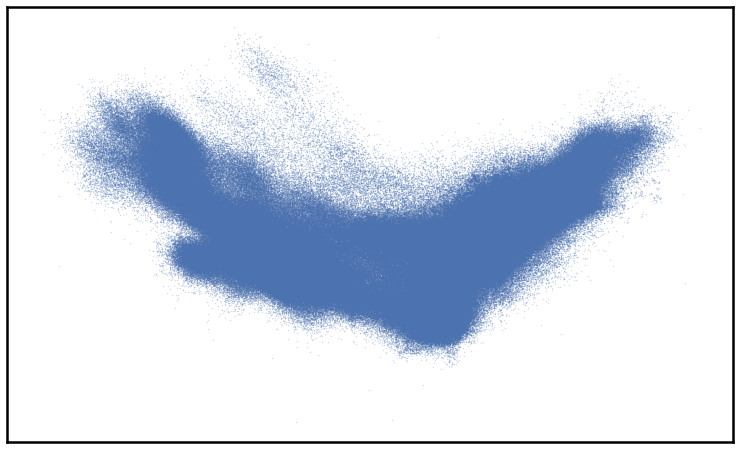

In [121]:
plt.scatter(x.lda_1, x.lda_2, c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [37]:
def plot_clusters(data, algorithm, args, kwds, col_plot=(0,1)):
    start_time = time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time()
    
    type(labels)
    len(labels)
    
    sample = data.copy()
    sample["labels"] = labels
    sample = sample.sample(10000)
    
    palette = sns.color_palette('deep', np.unique(sample.labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in sample.labels]
    
    plot_kwds = {'alpha' : 0.25, 's' : 20, 'linewidths':0}
    
    plt.scatter(sample[sample.columns[col_plot[0]]], sample[sample.columns[col_plot[1]]], 
                c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    
    return labels

In [38]:
np_scaled = scale(all_df[cols_kmers])

/home/ubuntu/.pyenv/versions/3.7.3/envs/py373/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint16 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


In [39]:
pd_scaled = pd.DataFrame(np_scaled, index=all_df.index, columns=cols_kmers)

In [40]:
pd_scaled.sample(3)

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
252,1.26,1.06,0.54,1.46,0.36,-0.62,-1.59,1.59,-0.28,-0.54,...,-0.88,1.40,0.52,1.13,0.95,3.72,2.87,0.67,2.25,3.05
532,0.29,0.94,0.39,0.25,2.56,0.77,0.87,1.54,0.44,0.75,...,-0.72,0.10,0.85,0.15,-0.30,0.39,0.63,0.04,-0.02,0.20
71,1.91,0.47,1.89,1.18,1.19,-1.09,-1.96,1.04,2.27,-0.17,...,-1.59,2.05,1.99,0.32,0.30,0.52,1.51,1.77,0.69,2.35


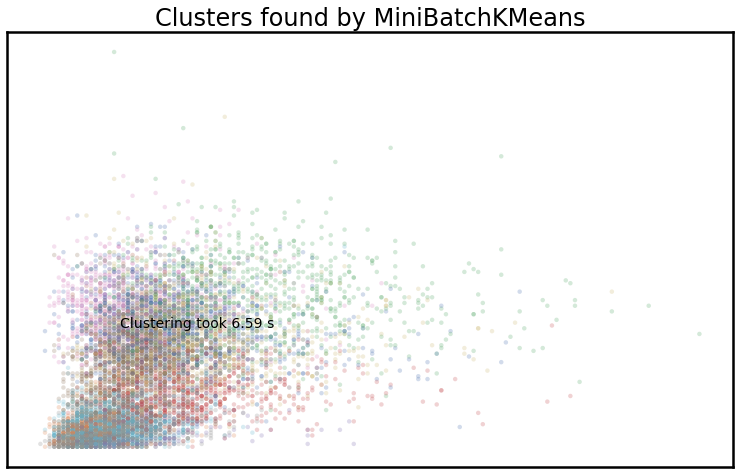

In [178]:
labels = plot_clusters(pd_scaled, cluster.MiniBatchKMeans, (), {'n_clusters':10}, (34, 176))


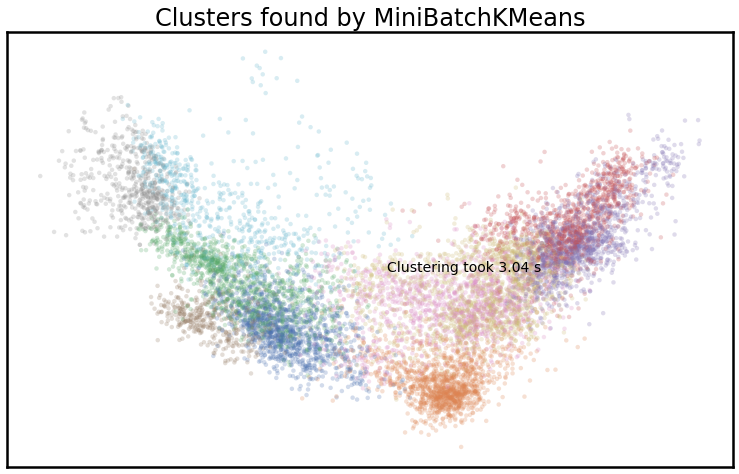

In [41]:
labels = plot_clusters(x[cols_lda], cluster.MiniBatchKMeans, (), {'n_clusters':10})

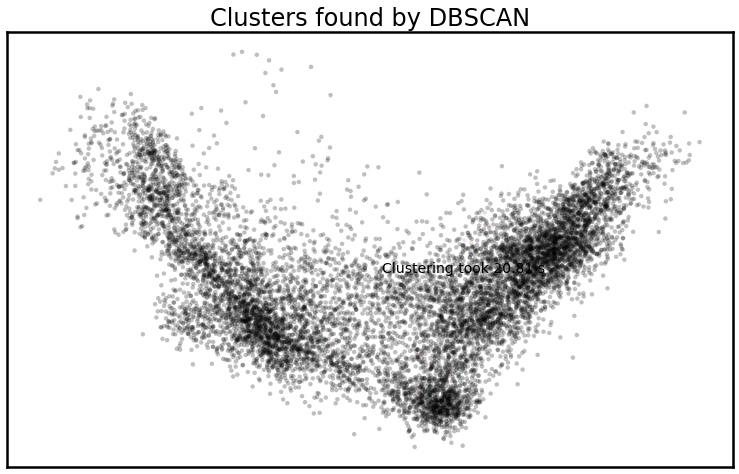

In [162]:
plot_clusters(x[cols_lda], cluster.DBSCAN, (), {'eps':0.025})

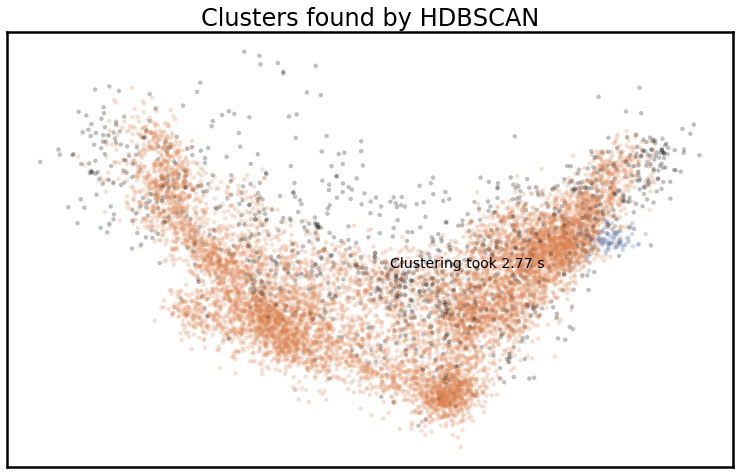

In [158]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

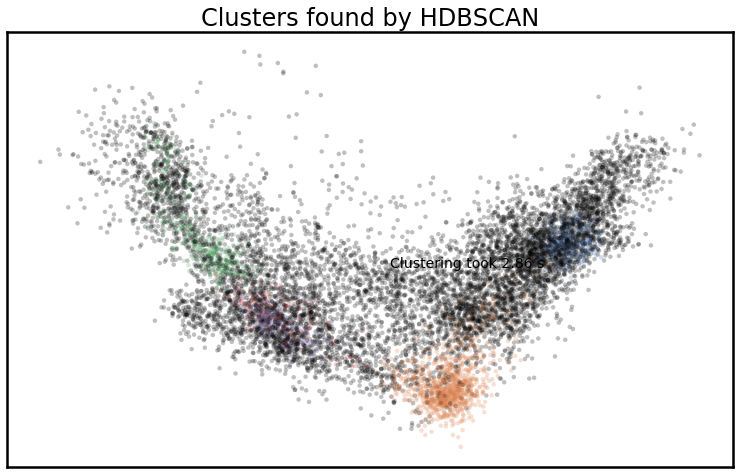

In [161]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':100})

In [ ]:
plot_clusters(pd_scaled, hdbscan.HDBSCAN, (), {'min_cluster_size':100})

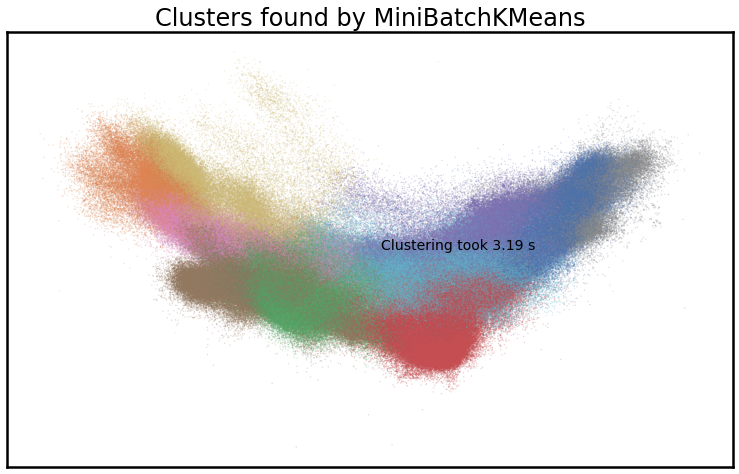

In [130]:
plot_clusters(x[cols_lda], cluster.MiniBatchKMeans, (), {'n_clusters':10})

## Checking if clusters make sense

In [42]:
x.sample(3)

,bacteria,fna,len_genome,start,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,...,lda_12,lda_13,lda_14,lda_15,lda_16,lda_17,lda_18,lda_19,lda_20,color_map
836215,Treponema_pallidum_Nichols_uid57585,NC_000919,1138011,560000,0.55,0.45,-1.73,2.95,1.96,-1.97,...,-1.52,-0.04,3.83,-0.71,-1.67,0.84,0.34,3.82,0.72,2452
805175,Bacillus_amyloliquefaciens_plantarum_CAU_B946_...,NC_016784,4019861,2930000,3.06,-3.03,-3.48,5.76,-0.24,-4.73,...,2.46,1.30,1.45,1.37,-0.28,0.65,-1.64,0.68,-1.84,2363
54785,Chlamydia_psittaci_NJ1_uid175579,NC_018626,1161434,0,6.80,3.12,-2.20,1.63,2.52,-3.10,...,-2.78,3.37,2.41,0.66,-0.21,-0.97,3.41,2.59,1.91,160


In [44]:
labels.shape, x.shape

((953797,), (953797, 25))

In [45]:
x["labels"] = labels

In [115]:
x_val = []
y_val = []
bac_name = []
nb_examples = 12
for bac in random.choices(x.bacteria.unique(), k=nb_examples):
    clusters = Counter(x[x.bacteria == bac].labels)
    clusters = dict(clusters)
    for key in range(10):
        if key not in clusters.keys():
            clusters[key] = 0
    x_val.append(list(clusters.keys()))
    y_val.append(list(clusters.values()))
    bac_name.append(bac)

In [116]:
sns.set_context("paper")
# sns.set_context("notebook", font_scale=1.25)
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 2, 'linewidths':0}

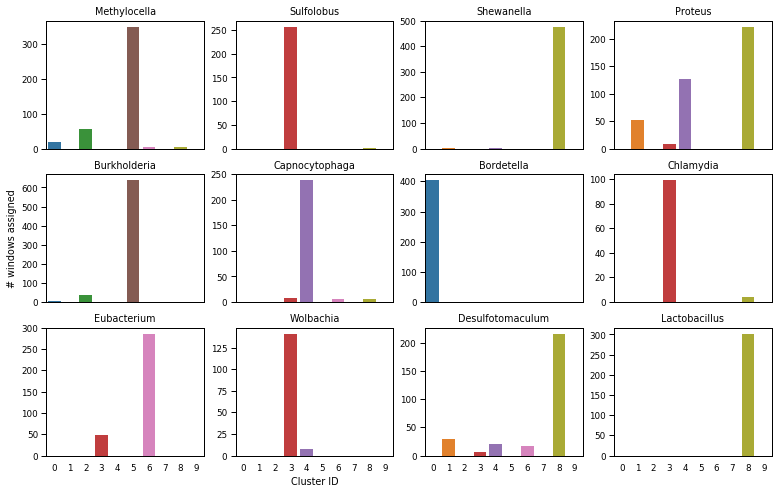

In [117]:
for i in range(nb_examples):
    plt.subplot(3, 4, i+1)
    sns.barplot(x_val[i], y_val[i])
    plt.title(bac_name[i].split("_")[0])
    
    if i+1 == 10: plt.xlabel("Cluster ID")
    if i+1 == 5: plt.ylabel("# windows assigned")
    
    if i+1 >= 9: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    else:        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

## K Means

In [94]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=seed)

In [95]:
kmeans.fit(x[cols_lda])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=84, tol=0.0001, verbose=0)

In [96]:
y_km = kmeans.predict(x[cols_lda])

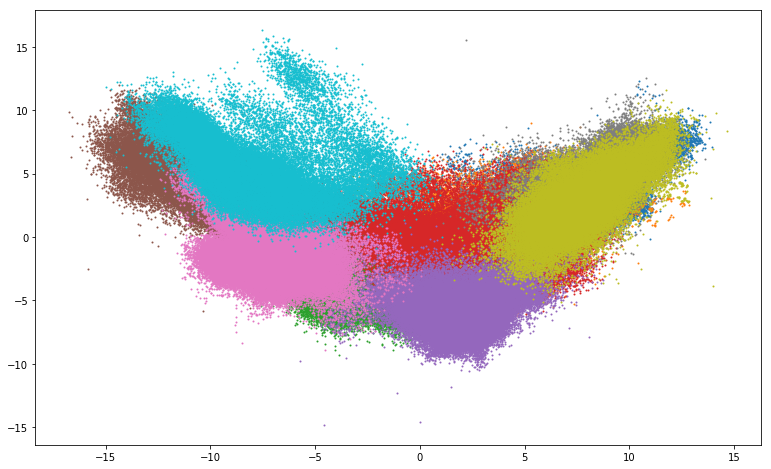

In [97]:
for c in range(n_clusters):
    plt.scatter(x["lda_1"][y_km == c], x["lda_2"][y_km == c], s=1)

In [98]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_kmeans_{now}.pkl", 'wb') as f: 
    pickle.dump(kmeans, f)

## Agglomerate clustering

In [77]:
data = x[cols_lda].sample(10000)

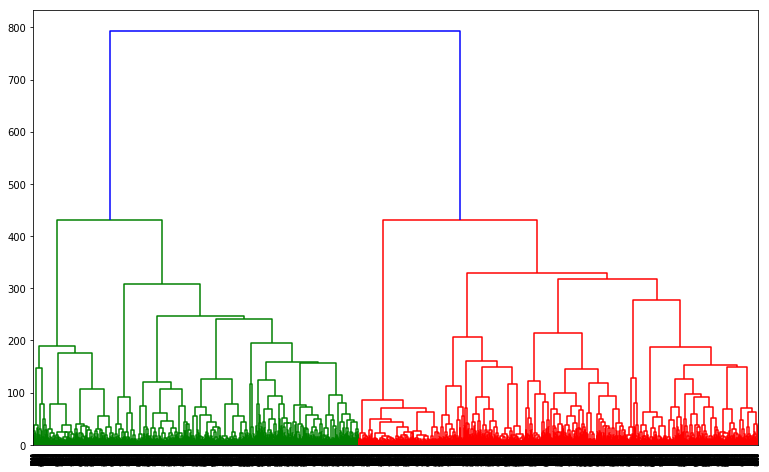

In [78]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
# create clusters
print("Create clusters...")
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
print("save them")
y_hc = hc.fit_predict(data)

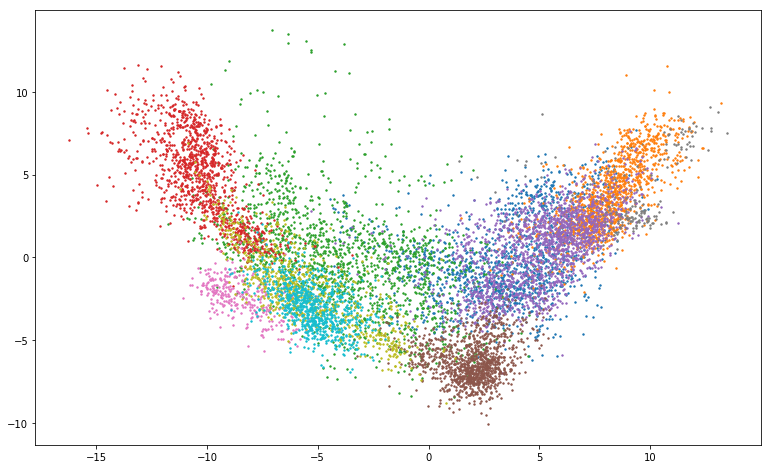

In [81]:
for c in range(n_clusters):
    plt.scatter(data["lda_1"][y_hc == c], data["lda_2"][y_hc == c], s=2)

In [85]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_agglo_{now}.pkl", 'wb') as f: 
    pickle.dump(hc, f)

## Mini Batch KMeans

In [99]:
minikm = MiniBatchKMeans(n_clusters=n_clusters, random_state=seed, batch_size=1000, max_iter=100)

In [100]:
minikm.fit(x[cols_lda])

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=84, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [101]:
y_mini = minikm.predict(x[cols_lda])

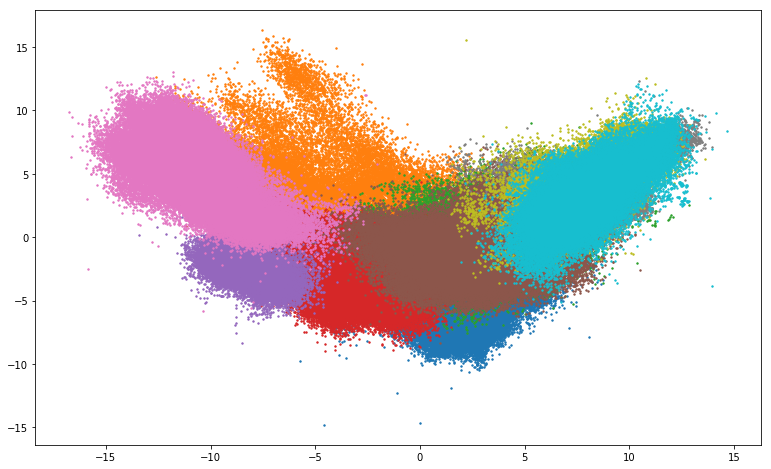

In [102]:
for c in range(n_clusters):
    plt.scatter(x["lda_1"][y_mini == c], x["lda_2"][y_mini == c], s=2)

## Combining results

In [104]:
class Cluster:
    def __init__(self, name, model, prediction):
        self.name = name
        self.model = model
        self.pred = prediction
        

In [105]:
models = [
    Cluster("kmeans", kmeans, y_km),
    Cluster("agglo", hc, y_hc),
    Cluster("minikm", minikm, y_mini),
]

# Evaluation

In [113]:
[len(model.pred) for model in models]

[953797, 10000, 953797]

In [110]:
pd_pred = pd.DataFrame({
    model.name: model.pred for model in models
})

ValueError: arrays must all be same length



### End of the script.
Sylvain @GIS

In [ ]:
ranking_ml(pd_res, 1000)

In [ ]:
pd_res

In [ ]:
pd_res[f"RF_pred"].str.split("_", 2).str[1]

In [ ]:
pd_res.Ground_Truth.str.split("_", 1).str[0] == pd_res[f"RF_pred"].str.split("_", 1).str[0]

In [ ]:
pd_res.Ground_Truth == pd_res[f"RF_pred"]

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
n_samples = 10000
n_bacteria = 100
random_seed = 0
dim_reduc_tool = "PCA"
components = 10
test_ratio = 0.1

In [ ]:
name_run = f"_{dim_reduc_tool}-{components}_{n_samples}-samples_{n_bacteria}-bac"

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
y = all_df["bacteria"]
x = all_df[cols_kmers]

In [ ]:
# average each row ?

In [ ]:
x, y = dim_reduc[dim_reduc_tool](x, y, components)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

In [ ]:
models_names = ['RF', 'SVM_lin', 'SVM_rbf', 'KNeigh', 'DTree', 'NNet', 'Naive_Bayes', 'QDA']

In [ ]:
results = launch_models(models_names, X_train, y_train, X_test, y_test, path_models, )  # name_run

In [ ]:
pd_res = pred_accuracy(results, y_test)
pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
pd_res.shape

In [ ]:
pd_ranking = ranking_ml(pd_res, test_ratio * n_samples)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

In [ ]:
class subSample:
    """ Attempt to use Pipeline correctly
        Select a subset of the available bacteria, and subsample again a number of windows
    """
    
    def __init__(self, n_samples=10000, n_species=100, random_state=0):
        self.n_samples = n_samples
        self.n_species = n_species
        self.random_state = random_state
        self._queried = None
        
    def fit(self, X, y):
        assert len(X) > self.n_samples, f"Dataset has less rows ({len(X)}) than the requested number of samples"
        assert len(y.unique()) > self.n_species, f"Dataset has less number of species "\
                                                 f"({len(y.unique())}) than the requested number of samples"
        if self.n_species < 0:
            self._queried = y.index
        else:
            self._queried = y[y.values.isin(y.unique()[:self.n_species])].index
        return self
    
    def transform(self, X, y=None):
        if y is None:
            if self.n_samples < 0:
                return X.iloc[self._queried]
            return X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state)
        else:
            if self.n_samples < 0:
                return (X.iloc[self._queried],
                        y.iloc[self._queried]
                       )
            return (X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state),
                    y.iloc[self._queried].sample(self.n_samples, random_state=self.random_state))
        
        return 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
subSam = subSample()

In [ ]:
subSam.fit(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
X, y = subSam.fit_transform(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
res[0].shape

In [ ]:
n_samples = 10000
n_bacteria = 100

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
all_all_df.shape, all_df.shape

In [ ]:
# Raw data
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
y_test = all_all_df["bacteria"]

In [ ]:
queried = y_test[y_test.values.isin(y_test.unique()[:n_bacteria])].index

In [ ]:
all_all_df.iloc[queried].sample(5).shape

## Machine Learning classification

In [ ]:
cols_spe

In [ ]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_pca]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [ ]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [ ]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 40 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 10 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, with PCA, 10 features

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 10,000 samples from 100 species, with PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

In [ ]:
pd_res

In [ ]:
all_df.sample(5)

In [ ]:
all_df[all_df.fna.str.contains("NC")].shape

In [ ]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

In [ ]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

In [ ]:
y_test

In [ ]:
df_pca1000.bacteria



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val